Conv1D를 적용하지 않은 경우

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [4]:
with open('Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [5]:
words_list = [doc.strip().split() for doc in texts]

In [6]:
total_words = []
for words in words_list:
    total_words.extend(words)

In [7]:
from collections import Counter
c = Counter(total_words)

In [8]:
len(c)

52011

In [9]:
max_features = 20000
common_words = [ word for word, count in c.most_common(max_features)]
# 빈도를 기준으로 상위 20000개의 단어들만 선택

In [10]:
# 각 단어에 대해서 index 생성하기
words_dic ={}
for index, word in enumerate(common_words):
    words_dic[word]=index+1

In [11]:
# 각 문서를 상위 20000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

In [12]:
from tensorflow.keras.preprocessing import sequence
max_len = 24
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)

In [13]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=0)

In [14]:
X_train.shape

(148845, 24)

In [15]:
num_classes = 2 # 종속변수값이 수 = 2
token_emb = 32 # 각 토큰을 32 차원의 벡터로 표현
patch_size = 4  # 패치 크기
num_patches = (max_len//patch_size)*(token_emb//patch_size)
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 2
mlp_head_units = [512, 64] 

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=(max_len,))
    data = layers.Embedding(max_features+1, token_emb)(inputs)
    data = tf.expand_dims(data, -1)
    
    patches = Patches(patch_size)(data)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    output = layers.Dense(num_classes, activation='softmax')(features) # 출력층

    model = keras.Model(inputs=inputs, outputs=output) # 모델 생성
    return model

In [22]:
vit_classifier = create_vit_classifier()

In [23]:
vit_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 24, 32)       640032      ['input_2[0][0]']                
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 24, 32, 1)    0           ['embedding_2[0][0]']            
                                                                                                  
 patches_1 (Patches)            (None, None, 16)     0           ['tf.expand_dims_1[0][0]']       
                                                                                            

In [28]:
from tensorflow.keras.utils import to_categorical 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [29]:
y_train_one_hot

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [30]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=0.0001, weight_decay=0.0001
)
vit_classifier.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
checkpoint_filepath = "./checkpoints/checkpoint_vit1"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min',
                     save_best_only=True,
                    save_weights_only=True,)

In [32]:
history = vit_classifier.fit(
    x=X_train,
    y=y_train_one_hot,
    batch_size=256,
    epochs=5,
    validation_split=0.1,
    callbacks=[mc,es],
)

Epoch 1/5
524/524 [==============================] - 234s 441ms/step - loss: 0.6724 - accuracy: 0.5754 - val_loss: 0.3661 - val_accuracy: 0.8311
Epoch 2/5
524/524 [==============================] - 231s 440ms/step - loss: 0.3267 - accuracy: 0.8708 - val_loss: 0.2721 - val_accuracy: 0.8869
Epoch 3/5
524/524 [==============================] - 231s 440ms/step - loss: 0.2579 - accuracy: 0.9024 - val_loss: 0.2833 - val_accuracy: 0.8846
Epoch 3: early stopping


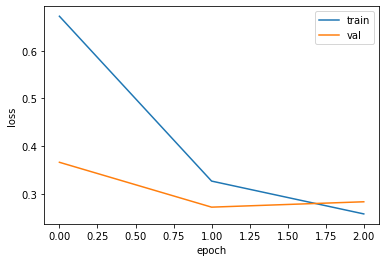

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [34]:
vit_classifier.evaluate(X_test, y_test_one_hot)

517/517 [==============================] - 11s 21ms/step - loss: 0.2788 - accuracy: 0.8888


[0.27877911925315857, 0.8888082504272461]

In [35]:
vit_classifier.load_weights(checkpoint_filepath)

In [36]:
vit_classifier.evaluate(X_test, y_test_one_hot)

517/517 [==============================] - 10s 20ms/step - loss: 0.2704 - accuracy: 0.8899


[0.2704474925994873, 0.8898966312408447]

In [40]:
y_prediction_probs = vit_classifier.predict(X_test)

517/517 [==============================] - 10s 20ms/step


In [42]:
y_preds = np.argmax(y_prediction_probs, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_preds, y_test))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      8065
           1       0.88      0.91      0.89      8474

    accuracy                           0.89     16539
   macro avg       0.89      0.89      0.89     16539
weighted avg       0.89      0.89      0.89     16539

